## Step 1: Setup & Data Structures
We define strict Pydantic models for every node's output.

In [11]:
import os
import json
from typing import List, Optional, TypedDict, Annotated
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langgraph.graph import END, StateGraph
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from huggingface_hub import InferenceClient
from dotenv import load_dotenv



In [12]:
load_dotenv()

# --- 1. Load Your Existing Resources ---
embeddings = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-mpnet-base-v2",
    model_kwargs={"device": "cpu"},
    encode_kwargs={"normalize_embeddings": True}
)

# Load Vector DB
VECTOR_DB_PATH = "./vector_db/faiss_lmkr"
try:
    vectorstore = FAISS.load_local(VECTOR_DB_PATH, embeddings, allow_dangerous_deserialization=True)
    retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
except:
    # Fallback for testing
    print("⚠️ DB not found, creating dummy.")
    vectorstore = FAISS.from_texts(["LMKR founded in 1994."], embeddings)
    retriever = vectorstore.as_retriever()

# LLM Client
hf_client = InferenceClient(
    model="mistralai/Mistral-7B-Instruct-v0.2",
    token=os.getenv("HF_API_TOKEN")
)

# --- 2. Define Structured Outputs (Pydantic) ---

class SearchPlan(BaseModel):
    """Output for Thinking Bot"""
    reasoning: str = Field(description="Why we need to search this")
    search_queries: List[str] = Field(description="List of 1-3 optimized search queries")

class ActionResponse(BaseModel):
    """Output for Action Bot"""
    answer: str = Field(description="The final answer to the user")
    used_context: str = Field(description="The specific context snippets used")

class EvaluationReport(BaseModel):
    """Output for Evaluation Bot"""
    score: int = Field(description="Score from 1-10")
    is_grounded: bool = Field(description="True if answer is supported by context")
    explanation: str = Field(description="Reason for the score")
    
# --- 3. Define Graph State ---

class AgentState(TypedDict):
    question: str
    plan: Optional[SearchPlan]
    response: Optional[ActionResponse]
    evaluation: Optional[EvaluationReport]
    retry_count: int

## Step 2: Helper for Mistral JSON Enforcement
Since Mistral can be chatty, this helper ensures we get clean JSON.

In [13]:
def query_llm_structured(prompt_text: str, parser: PydanticOutputParser) -> Optional[BaseModel]:
    """
    Wraps HF Client to force Pydantic output using Chat Completion API.
    """
    format_instructions = parser.get_format_instructions()
    
    # 1. Construct the prompt with strict JSON instructions
    final_prompt = f"""{prompt_text}
    
    IMPORTANT: You must output ONLY a valid JSON object. Do not add markdown formatting or conversational filler.
    {format_instructions}
    """
    
    # 2. CHANGE: Use chat_completion instead of text_generation
    try:
        messages = [{"role": "user", "content": final_prompt}]
        
        response = hf_client.chat_completion(
            messages=messages,
            max_tokens=500,       # Note: Parameter is 'max_tokens' for chat, not 'max_new_tokens'
            temperature=0.1       # Low temp for structure
        )
        
        # 3. Extract the actual text content from the Chat response object
        json_str = response.choices[0].message.content.strip()

        # 4. Clean Markdown if present (Common issue with Mistral)
        if "```json" in json_str:
            json_str = json_str.split("```json")[1].split("```")[0].strip()
        elif "```" in json_str:
            json_str = json_str.split("```")[1].split("```")[0].strip()
        
        # 5. Parse
        return parser.parse(json_str)

    except Exception as e:
        print(f"❌ JSON Parsing/API Failed: {e}")
        # print(f"Raw Output: {json_str}") # Uncomment to debug raw string
        return None

## Step 3: Define The 3 Nodes

In [14]:
# --- NODE 1: THINKING BOT ---
def thinking_node(state: AgentState):
    print("\n🧠 Thinking Bot: Analyzing request...")
    question = state["question"]
    
    parser = PydanticOutputParser(pydantic_object=SearchPlan)
    
    prompt = f"""
    User Question: {question}
    
    Task: Break this down into search queries for a vector database containing LMKR company data.
    If the question is simple, just generate one query.
    """
    
    structured_output = query_llm_structured(prompt, parser)
    
    # Fallback if parsing fails
    if not structured_output:
        structured_output = SearchPlan(reasoning="Parse failed", search_queries=[question])
        
    return {"plan": structured_output}


# --- NODE 2: ACTION BOT ---
def action_node(state: AgentState):
    print("\n⚡ Action Bot: Executing plan...")
    plan = state["plan"]
    
    # 1. Retrieve Data based on plan
    all_docs = []
    for query in plan.search_queries:
        docs = retriever.invoke(query)
        all_docs.extend(docs)
    
    # Deduplicate and Format
    unique_content = list(set([d.page_content for d in all_docs]))
    context_str = "\n---\n".join(unique_content[:3]) # Limit context size
    
    # 2. Generate Answer
    parser = PydanticOutputParser(pydantic_object=ActionResponse)
    
    prompt = f"""
    Context: {context_str}
    
    User Question: {state['question']}
    
    Task: Answer the question using ONLY the context provided.
    """
    
    structured_output = query_llm_structured(prompt, parser)
    
    return {"response": structured_output}


# --- NODE 3: EVALUATION BOT ---
def evaluation_node(state: AgentState):
    print("\n⚖️ Evaluation Bot: Grading answer...")
    response = state["response"]
    question = state["question"]
    
    parser = PydanticOutputParser(pydantic_object=EvaluationReport)
    
    prompt = f"""
    Question: {question}
    Generated Answer: {response.answer}
    Context Used: {response.used_context}
    
    Task: Evaluate if the answer is grounded in the context and accurate.
    """
    
    structured_output = query_llm_structured(prompt, parser)
    
    return {"evaluation": structured_output}

## Step 4: Build Graph & Logic

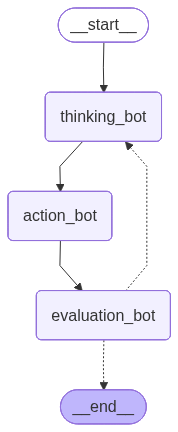

In [168]:
# --- Logic for Conditional Edge ---
def route_after_eval(state: AgentState):
    """
    Decide: End or Retry?
    """
    evaluation = state["evaluation"]
    retry_count = state.get("retry_count", 0)
    
    if evaluation and evaluation.is_grounded:
        print("✅ Answer Approved")
        return END
    
    if retry_count > 2:
        print("🛑 Max retries reached. Stopping.")
        return END
        
    print("🔄 Answer Rejected. Retrying Thinking...")
    return "thinking_bot"

# --- Graph Construction ---
workflow = StateGraph(AgentState)

# Add Nodes
workflow.add_node("thinking_bot", thinking_node)
workflow.add_node("action_bot", action_node)
workflow.add_node("evaluation_bot", evaluation_node)

# Add Edges
workflow.set_entry_point("thinking_bot")
workflow.add_edge("thinking_bot", "action_bot")
workflow.add_edge("action_bot", "evaluation_bot")

# Conditional Edge from Evaluation
workflow.add_conditional_edges(
    "evaluation_bot",
    route_after_eval,
    {
        END: END,
        "thinking_bot": "thinking_bot"
    }
)

app = workflow.compile()

# Visualize
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

## Step 5: Execution

In [20]:
# Test it
initial_state = {
    "question": "What is gverse?",
    "retry_count": 0
}

print("🚀 Starting Structured LangGraph...")

# CHANGE: Use .invoke() to get the complete final state dictionary
# The print statements inside your nodes will still show up!
final_state = app.invoke(initial_state)

# Now we can safely access all parts of the state
print("\n🎉 Final Output:")

if final_state.get('response'):
    print(f"Answer: {final_state['response'].answer}")
else:
    print("Answer: N/A")

if final_state.get('evaluation'):
    print(f"Evaluation: {final_state['evaluation'].score}/10")
    print(f"Reasoning: {final_state['evaluation'].explanation}")
else:
    print("Evaluation: N/A")

🚀 Starting Structured LangGraph...

🧠 Thinking Bot: Analyzing request...

⚡ Action Bot: Executing plan...

⚖️ Evaluation Bot: Grading answer...
✅ Answer Approved

🎉 Final Output:
Answer: GVERSE is a geoscience software solution offered by LMKR.
Evaluation: 10/10
Reasoning: The answer 'GVERSE is a geoscience software solution offered by LMKR' is directly stated in the context 'GVERSE GeoGraphix Release 2026.1'.
